# 20490033 - ERAY ÖKSÜZ - NESNE TABANLI PROGRAMLAMA FİNAL
# FELÇ TAHMİNLERİ

## Veri Seti Ne İçin?
Dünya Sağlık Örgütüne göre inme toplam ölüm sayısının %11'ini kapsayarak 2. önde gelen ölüm sebebidir. Cinsiyet, yaşadığı bölge, sigara, çalışma, evlilik, hipertansiyon, vücut kitle indeksi ve kalp hastalığı gibi veriler ile felç geçirme olasılığını tahmin eder.

## Verilerin Alınması ve Analizi

In [1]:
import numpy as np
import pandas as pd
df = pd.read_csv("healthcare-dataset-stroke-data.csv", sep=",")

In [2]:
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
# object türlerinde hangi değerlerin olduğuna bakıyorum.
for d in df:
    if(df[d].dtypes=="object"):
        print(d, ": ", df[d].unique())

gender :  ['Male' 'Female' 'Other']
ever_married :  ['Yes' 'No']
work_type :  ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type :  ['Urban' 'Rural']
smoking_status :  ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [5]:
# Other adında bir tane cinsiyet bunu kaldıracağım.
df["gender"].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [6]:
# Other olan cinsiyetin verileri
df[df["gender"] == "Other"]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0


In [7]:
df.drop(df[df["gender"]=="Other"].index, inplace=True)
df.reset_index(drop=True, inplace=True) #3116. satır silindiği için satır sayılarını baştan sayar.
df["gender"].unique()

array(['Male', 'Female'], dtype=object)

In [8]:
# Sonuçlardan kaç tane olduğuna bakıyorum. Felçli olanlar ile olmayanlar arasında baya fark var. 
# Dengesiz olduğu için tahmin algoritmaları düzgün çalışmayacaktır. Bu yüzden bu verileri eşitlemek gerekecek.
df["stroke"].value_counts()

0    4860
1     249
Name: stroke, dtype: int64

In [9]:
# Kaç tane NaN değeri olduğuna bakıyorum.
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [10]:
# bmi - vücut kitle endeksinde 201 tane NaN değeri var. Felçli olan veya olmayanlarda kaç tane eksik
# bmi olduğunu öğrenelim ilk.

print("Felç geçirmeyen", df[df["stroke"] == 0]["bmi"].isnull().sum())
print("Felç geçiren", df[df["stroke"] == 1]["bmi"].isnull().sum())

Felç geçirmeyen 161
Felç geçiren 40


### NaN değerlerini ne yapabilirim?
Tahmin edebilmek için bu NaN değerlerinden kurtulmak gerekiyor. 
NaN değeri olan satırları silebiliriz ya da silmek yerine NaN olmayan bmi değerlerinin ortalamasını ekleyebiliriz.
Fakat ortalamasını almak tahmin seviyesini etkileyeceği için NaN doldurma işlemi
için cinsiyet ve yaşa göre NaN bmi'yi tahmin etmesi tahmin algoritmasından faydalanacağım.

### NaN değerleri işleme


In [11]:
# Önce tahmin için kullanılacak verileri hazırlıyorum.

x_bmi = df[["age", "gender", "bmi"]].copy()
x_bmi

,age,gender,bmi
0,67.0,Male,36.6
1,61.0,Female,NaN
2,80.0,Male,32.5
3,49.0,Female,34.4
4,79.0,Female,24.0
...,...,...,...
5104,80.0,Female,NaN
5105,81.0,Female,40.0
5106,35.0,Female,30.6
5107,51.0,Male,25.6


In [12]:
#GCinsiyeti sayısala çeviriyorum.
x_bmi["gender"] = x_bmi["gender"].replace({'Male':0,'Female':1}).astype(np.uint8)
x_bmi

,age,gender,bmi
0,67.0,0,36.6
1,61.0,1,NaN
2,80.0,0,32.5
3,49.0,1,34.4
4,79.0,1,24.0
...,...,...,...
5104,80.0,1,NaN
5105,81.0,1,40.0
5106,35.0,1,30.6
5107,51.0,0,25.6


In [13]:
# bmi NaN değerlerini alıyorum.
kayipVeriler = x_bmi[x_bmi.bmi.isna()]
kayipVeriler

,age,gender,bmi
1,61.0,1,NaN
8,59.0,1,NaN
13,78.0,0,NaN
19,57.0,0,NaN
27,58.0,0,NaN
...,...,...,...
5038,41.0,0,NaN
5047,40.0,0,NaN
5092,45.0,1,NaN
5098,40.0,0,NaN


In [14]:
#Kayıp olmayan verileri alıyorum
x_bmi = x_bmi[~x_bmi.bmi.isna()]
x_bmi

,age,gender,bmi
0,67.0,0,36.6
2,80.0,0,32.5
3,49.0,1,34.4
4,79.0,1,24.0
5,81.0,0,29.0
...,...,...,...
5103,13.0,1,18.6
5105,81.0,1,40.0
5106,35.0,1,30.6
5107,51.0,0,25.6


In [15]:
# Tahmin için sonuç ve verileri ayırıyorum.
y_bmi = x_bmi["bmi"]
x_bmi = x_bmi.drop(["bmi"], axis=1)
x_bmi

,age,gender
0,67.0,0
2,80.0,0
3,49.0,1
4,79.0,1
5,81.0,0
...,...,...
5103,13.0,1
5105,81.0,1
5106,35.0,1
5107,51.0,0


In [16]:
y_bmi

0       36.6
2       32.5
3       34.4
4       24.0
5       29.0
        ... 
5103    18.6
5105    40.0
5106    30.6
5107    25.6
5108    26.2
Name: bmi, Length: 4908, dtype: float64

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

DT_bmi_pipe = Pipeline(steps=[
    ("scale", StandardScaler()),
    ("lr", DecisionTreeRegressor(random_state=42))
])

DT_bmi_pipe.fit(x_bmi,y_bmi)

Pipeline(steps=[('scale', StandardScaler()),
                ('lr', DecisionTreeRegressor(random_state=42))])

In [18]:
tahminEdilenBmi = pd.Series(DT_bmi_pipe.predict(
    kayipVeriler[
        ["age", "gender"]
    ]), 
    index=kayipVeriler.index)

tahminEdilenBmi

1       29.879487
8       30.556098
13      27.247222
19      30.841860
27      33.146667
          ...    
5038    32.716000
5047    28.313636
5092    31.459322
5098    28.313636
5104    28.476923
Length: 201, dtype: float64

In [19]:
# Tahmin edilen vücut kitle endekslerini ana verisetime ekliyorum artık
df.loc[kayipVeriler.index, "bmi"] = tahminEdilenBmi

print(df.isnull().sum())
df.head(5)

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,29.879487,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


Veri setindeki kayıp verileri böylelikle doldurdum. Felç tahminlerine geçmeden önce istatistikler ile verilerin felç riskini ne kadar etkilediğini görmeye geldi sıra.

# İstatistikler
## Pasta Grafiği ile Felçli olan ve Olmayanları Oranlama

In [20]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FormatStrFormatter

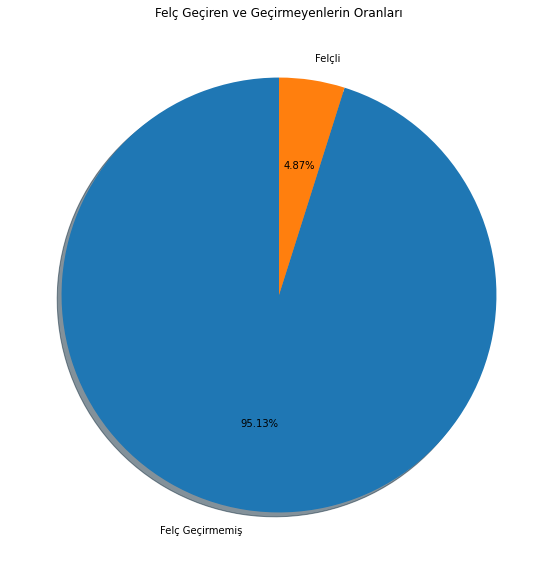

In [21]:
plt.figure(figsize=(10,10))
plt.pie([len(df[df["stroke"] == 0]), len(df[df["stroke"] == 1])],
        labels=["Felç Geçirmemiş", "Felçli"],
        startangle=90,
        autopct="%.2f%%",
        shadow=True
       )

plt.title("Felç Geçiren ve Geçirmeyenlerin Oranları")
plt.show()

## Cinsiyet Dağıtılımı

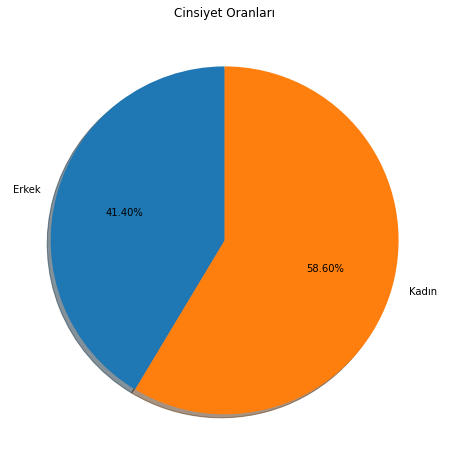

In [22]:
plt.figure(figsize=(8,8))
plt.pie([len(df[df["gender"] == "Male"]), len(df[df["gender"] == "Female"])],
        labels=["Erkek", "Kadın"],
        startangle=90,
        autopct="%.2f%%",
        shadow=True
       )

plt.title("Cinsiyet Oranları")
plt.show()

In [23]:
df["gender"].value_counts()

Female    2994
Male      2115
Name: gender, dtype: int64

## Cinsiyete Göre Felç Geçiren ve Geçirmeyen
### Grafik için verilerin analizi ve hazırlanması

In [24]:
istatistik_data = pd.DataFrame(columns=["Felç Geçiren", "Felç Geçiren Oranı", "Felç Geçirmeyen", "Felç Geçirmeyen Oranı"])
istatistik_data.insert(0, "Cinsiyet", df["gender"].unique())
istatistik_data.fillna(0, inplace=True)
istatistik_data

,Cinsiyet,Felç Geçiren,Felç Geçiren Oranı,Felç Geçirmeyen,Felç Geçirmeyen Oranı
0,Male,0,0,0,0
1,Female,0,0,0,0


In [25]:
for i in range(len(istatistik_data)):
    for d in range(len(df["stroke"])):
        if(df["gender"][d] == istatistik_data["Cinsiyet"][i] and df["stroke"][d] == 1):
            istatistik_data.loc[i, "Felç Geçiren"] += 1
        elif(df["gender"][d] == istatistik_data["Cinsiyet"][i] and df["stroke"][d] == 0):
            istatistik_data.loc[i, "Felç Geçirmeyen"] += 1 
istatistik_data["Cinsiyet"] = istatistik_data["Cinsiyet"].replace({"Male": "Erkek", "Female": "Kadın"})
istatistik_data

,Cinsiyet,Felç Geçiren,Felç Geçiren Oranı,Felç Geçirmeyen,Felç Geçirmeyen Oranı
0,Erkek,108,0,2007,0
1,Kadın,141,0,2853,0


### Bar Grafiği ile Gösterim

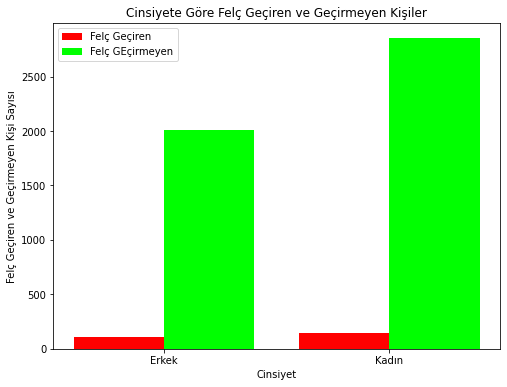

In [26]:
X_cinsiyet_axis = np.arange(len(istatistik_data["Cinsiyet"]))

plt.figure(figsize=(8,6))
plt.bar(X_cinsiyet_axis - 0.2, istatistik_data["Felç Geçiren"], 0.4, color="red", label = "Felç Geçiren")
plt.bar(X_cinsiyet_axis + 0.2, istatistik_data["Felç Geçirmeyen"], 0.4, color="lime", label = "Felç GEçirmeyen")
plt.xticks(X_cinsiyet_axis, istatistik_data["Cinsiyet"])
plt.xlabel("Cinsiyet")
plt.ylabel("Felç Geçiren ve Geçirmeyen Kişi Sayısı")
plt.title("Cinsiyete Göre Felç Geçiren ve Geçirmeyen Kişiler")
plt.legend()
plt.show()

## Cinsiyete Göre Felç Geçiren ve Geçirmeyenleri Oranlamak

In [27]:
for i in range(len(istatistik_data)):
    istatistik_data.loc[i, "Felç Geçiren Oranı"] = istatistik_data.loc[i, "Felç Geçiren"]/sum(istatistik_data["Felç Geçiren"])*100
    istatistik_data.loc[i, "Felç Geçirmeyen Oranı"] = istatistik_data.loc[i, "Felç Geçirmeyen"]/sum(istatistik_data["Felç Geçirmeyen"])*100
    
istatistik_data

,Cinsiyet,Felç Geçiren,Felç Geçiren Oranı,Felç Geçirmeyen,Felç Geçirmeyen Oranı
0,Erkek,108,43.373494,2007,41.296296
1,Kadın,141,56.626506,2853,58.703704


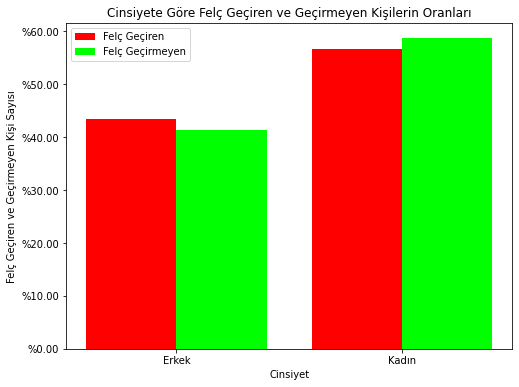

In [28]:
X_cinsiyet_axis = np.arange(len(istatistik_data["Cinsiyet"]))

plt.figure(figsize=(8,6))
plt.bar(X_cinsiyet_axis - 0.2, istatistik_data["Felç Geçiren Oranı"], 0.4, color="red", label = "Felç Geçiren")
plt.bar(X_cinsiyet_axis + 0.2, istatistik_data["Felç Geçirmeyen Oranı"], 0.4, color="lime", label = "Felç Geçirmeyen")
plt.xticks(X_cinsiyet_axis, istatistik_data["Cinsiyet"])
plt.xlabel("Cinsiyet")
plt.ylabel("Felç Geçiren ve Geçirmeyen Kişi Sayısı")
plt.title("Cinsiyete Göre Felç Geçiren ve Geçirmeyen Kişilerin Oranları")
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('%{x:,.2f}'))
plt.legend()
plt.show()

## Yaş Dağıtımları
### Grafik için verilerin analizi ve hazırlanması

In [29]:
minYas = df["age"].min()
maxYas = df["age"].max()

print("Min Yaş: ", minYas)
print("Max Yaş: ", maxYas)

Min Yaş:  0.08
Max Yaş:  82.0


In [30]:
yaslar = sorted(df["age"].unique())
print(yaslar)


[0.08, 0.16, 0.24, 0.32, 0.4, 0.48, 0.56, 0.64, 0.72, 0.8, 0.88, 1.0, 1.08, 1.16, 1.24, 1.32, 1.4, 1.48, 1.56, 1.64, 1.72, 1.8, 1.88, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0]


[2, 3, 5, 5, 2, 3, 5, 4, 5, 4, 5, 5, 8, 4, 8, 8, 3, 6, 4, 8, 6, 9, 8, 55, 46, 34, 65, 24, 32, 58, 38, 35, 36, 45, 57, 54, 45, 52, 60, 60, 50, 59, 47, 45, 64, 55, 57, 61, 55, 54, 51, 55, 79, 71, 57, 68, 54, 52, 76, 72, 71, 74, 73, 71, 70, 75, 85, 62, 75, 66, 79, 83, 86, 90, 85, 87, 83, 77, 95, 68, 80, 72, 76, 74, 74, 53, 62, 60, 49, 47, 54, 45, 61, 45, 46, 40, 53, 50, 42, 102, 85, 70, 60, 56]


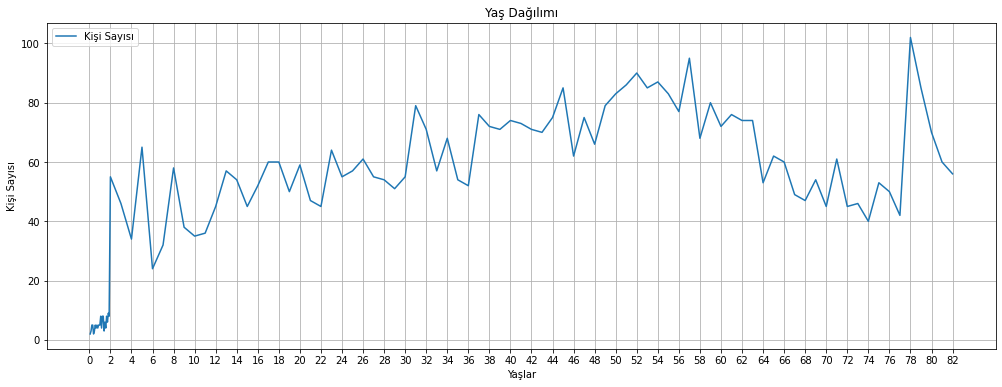

In [31]:
yasaGoreKisiSayisi = []

for y in yaslar:
    yasaGoreKisiSayisi.append(len(df[df["age"] == y]))

print(yasaGoreKisiSayisi)
    
plt.figure(figsize=(17,6))
plt.title("Yaş Dağılımı")
plt.plot(yaslar, yasaGoreKisiSayisi, label="Kişi Sayısı")
plt.grid(True)
plt.xticks(np.arange(0, max(yaslar)+2, 2))
plt.xlabel("Yaşlar")
plt.ylabel("Kişi Sayısı")
plt.legend()
plt.show()

## Cinsiyete Göre Yaş Dağılımı
### Grafik için verilerin analizi ve hazırlanması

[1, 3, 5, 2, 1, 1, 4, 2, 2, 3, 4, 4, 5, 0, 1, 3, 1, 1, 2, 5, 5, 3, 5, 29, 17, 23, 33, 15, 13, 32, 26, 21, 20, 22, 27, 27, 25, 22, 23, 27, 21, 21, 18, 13, 17, 18, 22, 17, 17, 16, 15, 20, 27, 27, 22, 26, 17, 18, 27, 23, 31, 26, 26, 24, 28, 30, 24, 31, 31, 28, 32, 28, 32, 36, 37, 39, 42, 30, 44, 36, 38, 32, 34, 33, 32, 27, 24, 25, 25, 17, 20, 19, 31, 19, 22, 16, 21, 22, 15, 42, 26, 28, 22, 23]
[1, 0, 0, 3, 1, 2, 1, 2, 3, 1, 1, 1, 3, 4, 7, 5, 2, 5, 2, 3, 1, 6, 3, 26, 29, 11, 32, 9, 19, 26, 12, 14, 16, 23, 30, 27, 20, 30, 37, 33, 29, 38, 29, 32, 47, 37, 35, 44, 38, 38, 36, 35, 52, 44, 35, 42, 37, 34, 49, 49, 40, 48, 47, 47, 42, 45, 61, 31, 44, 38, 47, 55, 54, 54, 48, 48, 41, 47, 51, 32, 42, 40, 42, 41, 42, 26, 38, 35, 24, 30, 34, 26, 30, 26, 24, 24, 32, 28, 27, 60, 59, 42, 38, 33]


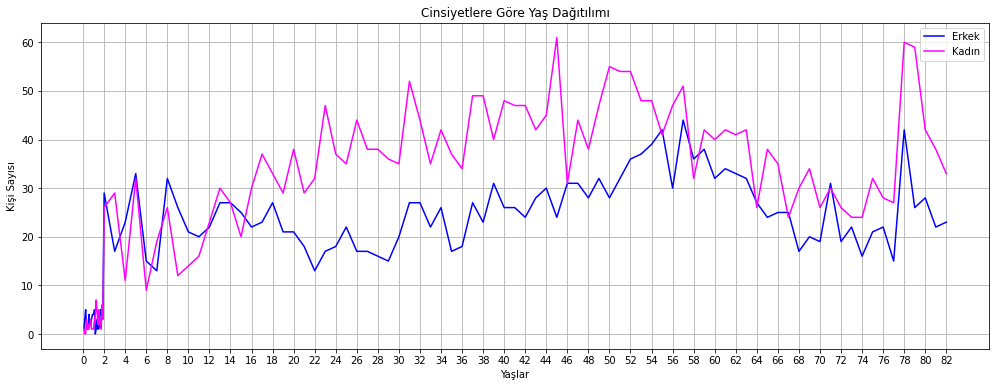

In [32]:
erkekYas = []
kadinYas = []
for y in yaslar:
    erkekYas.append(len(df.query('gender=="Male" and age==' + str(y))))
    kadinYas.append(len(df.query('gender=="Female" and age==' + str(y))))

print(erkekYas)
print(kadinYas)

plt.figure(figsize=(17,6))
plt.title("Cinsiyetlere Göre Yaş Dağıtılımı")
plt.plot(yaslar, erkekYas, color="blue", label="Erkek")
plt.plot(yaslar, kadinYas, color="magenta", label="Kadın")
plt.grid(True)
plt.xticks(np.arange(0, max(yaslar)+2, 2))
plt.xlabel("Yaşlar")
plt.ylabel("Kişi Sayısı")
plt.legend()
plt.show()

## Yaşa Göre Felç Geçirme Olasılığı

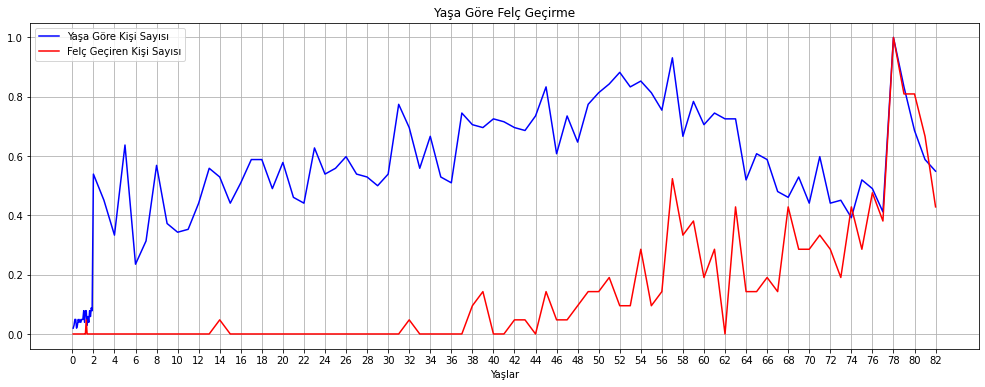

In [33]:
yasaGoreFelcGecirenler = []

for y in yaslar:
    yasaGoreFelcGecirenler.append(len(df.query('stroke==1 and age==' + str(y))))

yasaGoreFelcGecirenler = np.array(yasaGoreFelcGecirenler)
yasaGoreFelcGecirenler = yasaGoreFelcGecirenler/max(yasaGoreFelcGecirenler)

yasaGoreKisiSayisi2 = np.array(yasaGoreKisiSayisi)
yasaGoreKisiSayisi2 = yasaGoreKisiSayisi2/max(yasaGoreKisiSayisi2)



plt.figure(figsize=(17,6))
plt.title("Yaşa Göre Felç Geçirme")
plt.plot(yaslar, yasaGoreKisiSayisi2, color="blue", label="Yaşa Göre Kişi Sayısı")
plt.plot(yaslar, yasaGoreFelcGecirenler, color="red", label="Felç Geçiren Kişi Sayısı")
plt.grid(True)
plt.xticks(np.arange(0, max(yaslar)+2, 2))
plt.xlabel("Yaşlar")
plt.legend()
plt.show()

## Sigara Kullanım Oranları

### İstatistik için verilerin analizi

In [34]:
print(df["smoking_status"].unique())
df["smoking_status"].value_counts(sort=False)

['formerly smoked' 'never smoked' 'smokes' 'Unknown']


formerly smoked     884
never smoked       1892
smokes              789
Unknown            1544
Name: smoking_status, dtype: int64

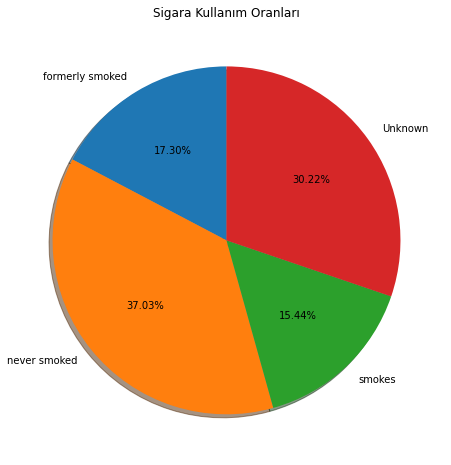

In [35]:
plt.figure(figsize=(8,8))
plt.pie(df["smoking_status"].value_counts(sort=False),
        labels=df["smoking_status"].unique(),
        startangle=90,
        autopct="%.2f%%",
        shadow=True
       )

plt.title("Sigara Kullanım Oranları")
plt.show()

## Sigara Kullanımına Göre Felç Geçirme Oranı
### İstatistik için verilerin analizi

In [36]:
istatistik_data2 = pd.DataFrame(columns=["Felç Geçiren", "Felç Geçiren Oran", "Felç Geçirmeyen", "Felç Geçirmeyen Oran"])
istatistik_data2.insert(0, "Sigara Kullanım", df["smoking_status"].unique())
istatistik_data2.fillna(0, inplace=True)
istatistik_data2

,Sigara Kullanım,Felç Geçiren,Felç Geçiren Oran,Felç Geçirmeyen,Felç Geçirmeyen Oran
0,formerly smoked,0,0,0,0
1,never smoked,0,0,0,0
2,smokes,0,0,0,0
3,Unknown,0,0,0,0


In [37]:
for i in range(len(istatistik_data2)):
    istatistik_data2.loc[i, "Felç Geçiren"] = len(df.query('smoking_status=="' + istatistik_data2.loc[i, "Sigara Kullanım"] + '" and stroke==1'))
    istatistik_data2.loc[i, "Felç Geçirmeyen"] = len(df.query('smoking_status=="' + istatistik_data2.loc[i, "Sigara Kullanım"] + '" and stroke==0'))
       
istatistik_data2

,Sigara Kullanım,Felç Geçiren,Felç Geçiren Oran,Felç Geçirmeyen,Felç Geçirmeyen Oran
0,formerly smoked,70,0,814,0
1,never smoked,90,0,1802,0
2,smokes,42,0,747,0
3,Unknown,47,0,1497,0


In [38]:
# Bar grafiğinde daha iyi karşılaştırma yapmak için oranlama
for i in range(len(istatistik_data2)):
    istatistik_data2.loc[i, "Felç Geçiren Oran"] = istatistik_data2.loc[i, "Felç Geçiren"]/sum(istatistik_data2["Felç Geçiren"])*100
    istatistik_data2.loc[i, "Felç Geçirmeyen Oran"] = istatistik_data2.loc[i, "Felç Geçirmeyen"]/sum(istatistik_data2["Felç Geçirmeyen"])*100
    
istatistik_data2

,Sigara Kullanım,Felç Geçiren,Felç Geçiren Oran,Felç Geçirmeyen,Felç Geçirmeyen Oran
0,formerly smoked,70,28.112450,814,16.748971
1,never smoked,90,36.144578,1802,37.078189
2,smokes,42,16.867470,747,15.370370
3,Unknown,47,18.875502,1497,30.802469


### Bar Grafiği İle Gösterimi

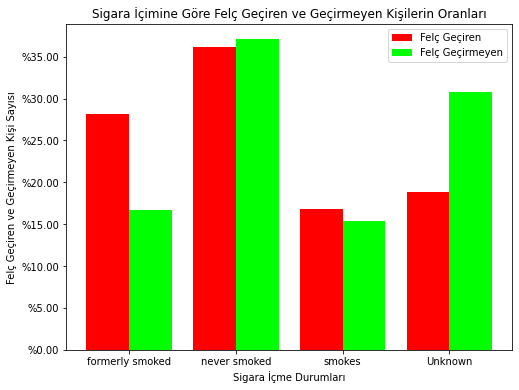

In [39]:
X_sigara_kullanim_axis = np.arange(len(istatistik_data2["Sigara Kullanım"]))

plt.figure(figsize=(8,6))
plt.bar(X_sigara_kullanim_axis - 0.2, istatistik_data2["Felç Geçiren Oran"], 0.4, color="red", label = "Felç Geçiren")
plt.bar(X_sigara_kullanim_axis + 0.2, istatistik_data2["Felç Geçirmeyen Oran"], 0.4, color="lime", label = "Felç Geçirmeyen")
plt.xticks(X_sigara_kullanim_axis, istatistik_data2["Sigara Kullanım"])
plt.xlabel("Sigara İçme Durumları")
plt.ylabel("Felç Geçiren ve Geçirmeyen Kişi Sayısı")
plt.title("Sigara İçimine Göre Felç Geçiren ve Geçirmeyen Kişilerin Oranları")
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('%{x:,.2f}'))
plt.legend()
plt.show()

## Hipertansiyonun Felç'e Etkisi 
### İstatistik için verilerin analizi ve hazırlanması


In [40]:
istatistik_data3 = pd.DataFrame(columns=["Felç Geçiren", "Felç Geçiren Oran", "Felç Geçirmeyen", "Felç Geçirmeyen Oran"])
istatistik_data3.insert(0, "hypertension", df["hypertension"].unique())
istatistik_data3.fillna(0, inplace=True)
istatistik_data3

,hypertension,Felç Geçiren,Felç Geçiren Oran,Felç Geçirmeyen,Felç Geçirmeyen Oran
0,0,0,0,0,0
1,1,0,0,0,0


In [41]:
for i in range(len(istatistik_data3)):
    istatistik_data3.loc[i, "Felç Geçiren"] = len(df.query('hypertension==' + str(istatistik_data3.loc[i, "hypertension"]) + ' and stroke==1'))
    istatistik_data3.loc[i, "Felç Geçirmeyen"] = len(df.query('hypertension==' + str(istatistik_data3.loc[i, "hypertension"]) + ' and stroke==0'))
       
istatistik_data3

,hypertension,Felç Geçiren,Felç Geçiren Oran,Felç Geçirmeyen,Felç Geçirmeyen Oran
0,0,183,0,4428,0
1,1,66,0,432,0


In [42]:
## Oranlama
for i in range(len(istatistik_data3)):
    istatistik_data3.loc[i, "Felç Geçiren Oran"] = istatistik_data3.loc[i, "Felç Geçiren"]/sum(istatistik_data3["Felç Geçiren"])*100
    istatistik_data3.loc[i, "Felç Geçirmeyen Oran"] = istatistik_data3.loc[i, "Felç Geçirmeyen"]/sum(istatistik_data3["Felç Geçirmeyen"])*100
    

istatistik_data3["hypertension"] = istatistik_data3["hypertension"].replace({0: "Hipertansiyon Öyküsü Yok", 1: "Hipertansiyon Öyküsü Var"})
istatistik_data3

,hypertension,Felç Geçiren,Felç Geçiren Oran,Felç Geçirmeyen,Felç Geçirmeyen Oran
0,Hipertansiyon Öyküsü Yok,183,73.493976,4428,91.111111
1,Hipertansiyon Öyküsü Var,66,26.506024,432,8.888889


### Bar Grafiği İle Gösterimi

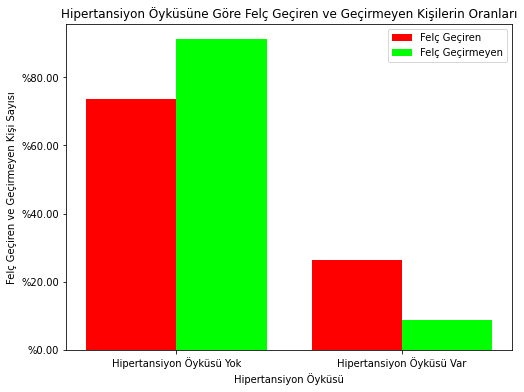

In [43]:
X_hypertension_axis = np.arange(len(istatistik_data3["hypertension"]))

plt.figure(figsize=(8,6))
plt.bar(X_hypertension_axis - 0.2, istatistik_data3["Felç Geçiren Oran"], 0.4, color="red", label = "Felç Geçiren")
plt.bar(X_hypertension_axis + 0.2, istatistik_data3["Felç Geçirmeyen Oran"], 0.4, color="lime", label = "Felç Geçirmeyen")
plt.xticks(X_hypertension_axis, istatistik_data3["hypertension"])
plt.xlabel("Hipertansiyon Öyküsü")
plt.ylabel("Felç Geçiren ve Geçirmeyen Kişi Sayısı")
plt.title("Hipertansiyon Öyküsüne Göre Felç Geçiren ve Geçirmeyen Kişilerin Oranları")
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('%{x:,.2f}'))
plt.legend()
plt.show()

## Kalp Hastalığının Felç'e Etkisi
### İstatistik için verilerin analizi ve hazırlanması


In [44]:
istatistik_data4 = pd.DataFrame(columns=["Felç Geçiren", "Felç Geçiren Oran", "Felç Geçirmeyen", "Felç Geçirmeyen Oran"])
istatistik_data4.insert(0, "heart_disease", df["heart_disease"].unique())
istatistik_data4.fillna(0, inplace=True)
istatistik_data4

,heart_disease,Felç Geçiren,Felç Geçiren Oran,Felç Geçirmeyen,Felç Geçirmeyen Oran
0,1,0,0,0,0
1,0,0,0,0,0


In [45]:
# Kişi sayısını bulma
for i in range(len(istatistik_data4)):
    istatistik_data4.loc[i, "Felç Geçiren"] = len(df.query('heart_disease==' + str(istatistik_data4.loc[i, "heart_disease"]) + ' and stroke==1'))
    istatistik_data4.loc[i, "Felç Geçirmeyen"] = len(df.query('heart_disease==' + str(istatistik_data4.loc[i, "heart_disease"]) + ' and stroke==0'))
       
# Kişi sayısını oranlama
for i in range(len(istatistik_data4)):
    istatistik_data4.loc[i, "Felç Geçiren Oran"] = istatistik_data4.loc[i, "Felç Geçiren"]/sum(istatistik_data4["Felç Geçiren"])*100
    istatistik_data4.loc[i, "Felç Geçirmeyen Oran"] = istatistik_data4.loc[i, "Felç Geçirmeyen"]/sum(istatistik_data4["Felç Geçirmeyen"])*100
    
# Başlık Değişimi
istatistik_data4["heart_disease"] = istatistik_data4["heart_disease"].replace({0: "Kalp Hastalığı Öyküsü Yok", 1: "Kalp Hastalığı Öyküsü Var"})
istatistik_data4

,heart_disease,Felç Geçiren,Felç Geçiren Oran,Felç Geçirmeyen,Felç Geçirmeyen Oran
0,Kalp Hastalığı Öyküsü Var,47,18.875502,229,4.711934
1,Kalp Hastalığı Öyküsü Yok,202,81.124498,4631,95.288066


### Bar Grafiği İle Gösterimi

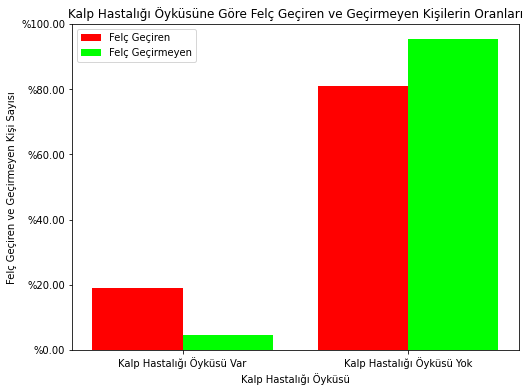

In [46]:
X_heart_disease_axis = np.arange(len(istatistik_data4["heart_disease"]))

plt.figure(figsize=(8,6))
plt.bar(X_heart_disease_axis - 0.2, istatistik_data4["Felç Geçiren Oran"], 0.4, color="red", label = "Felç Geçiren")
plt.bar(X_heart_disease_axis + 0.2, istatistik_data4["Felç Geçirmeyen Oran"], 0.4, color="lime", label = "Felç Geçirmeyen")
plt.xticks(X_heart_disease_axis, istatistik_data4["heart_disease"])
plt.xlabel("Kalp Hastalığı Öyküsü")
plt.ylabel("Felç Geçiren ve Geçirmeyen Kişi Sayısı")
plt.title("Kalp Hastalığı Öyküsüne Göre Felç Geçiren ve Geçirmeyen Kişilerin Oranları")
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('%{x:,.2f}'))
plt.legend()
plt.show()

## Çalışma Hayatı Dağılımı
### İstatistik için verilerin analizi

In [47]:
print(df["work_type"].unique())
df["work_type"].value_counts(sort=False)

['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']


Private          2924
Self-employed     819
Govt_job          657
children          687
Never_worked       22
Name: work_type, dtype: int64

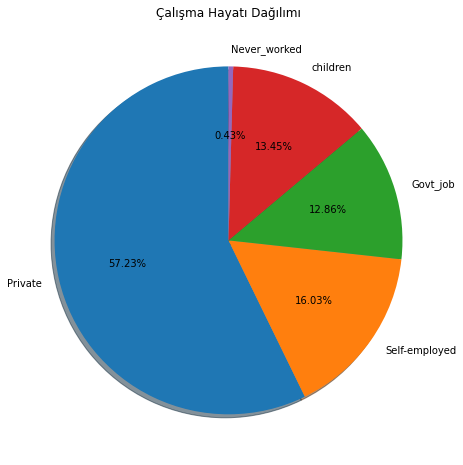

In [48]:
plt.figure(figsize=(8,8))
plt.pie(df["work_type"].value_counts(sort=False),
        labels=df["work_type"].unique(),
        startangle=90,
        autopct="%.2f%%",
        shadow=True
       )

plt.title("Çalışma Hayatı Dağılımı")
plt.show()

## Çalışma Hayatının Felç'e Etkisi
### İstatistik için verilerin analizi ve hazırlanması

In [49]:
istatistik_data5 = pd.DataFrame(columns=["Felç Geçiren", "Felç Geçiren Oran", "Felç Geçirmeyen", "Felç Geçirmeyen Oran"])
istatistik_data5.insert(0, "work_type", df["work_type"].unique())
istatistik_data5.fillna(0, inplace=True)
istatistik_data5

,work_type,Felç Geçiren,Felç Geçiren Oran,Felç Geçirmeyen,Felç Geçirmeyen Oran
0,Private,0,0,0,0
1,Self-employed,0,0,0,0
2,Govt_job,0,0,0,0
3,children,0,0,0,0
4,Never_worked,0,0,0,0


In [50]:
# Kişi sayısını bulma
for i in range(len(istatistik_data5)):
    istatistik_data5.loc[i, "Felç Geçiren"] = len(df.query('work_type=="' + str(istatistik_data5.loc[i, "work_type"]) + '" and stroke==1'))
    istatistik_data5.loc[i, "Felç Geçirmeyen"] = len(df.query('work_type=="' + str(istatistik_data5.loc[i, "work_type"]) + '" and stroke==0'))
       
# Kişi sayısını oranlama
for i in range(len(istatistik_data5)):
    istatistik_data5.loc[i, "Felç Geçiren Oran"] = istatistik_data5.loc[i, "Felç Geçiren"]/sum(istatistik_data5["Felç Geçiren"])*100
    istatistik_data5.loc[i, "Felç Geçirmeyen Oran"] = istatistik_data5.loc[i, "Felç Geçirmeyen"]/sum(istatistik_data5["Felç Geçirmeyen"])*100

istatistik_data5

,work_type,Felç Geçiren,Felç Geçiren Oran,Felç Geçirmeyen,Felç Geçirmeyen Oran
0,Private,149,59.839357,2775,57.098765
1,Self-employed,65,26.104418,754,15.514403
2,Govt_job,33,13.253012,624,12.839506
3,children,2,0.803213,685,14.094650
4,Never_worked,0,0.000000,22,0.452675


### Bar Grafiği İle Gösterim

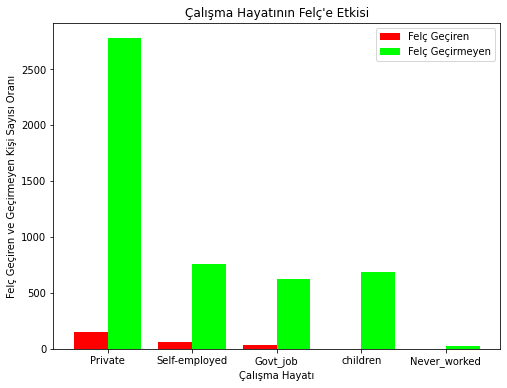

In [51]:
X_work_type_axis = np.arange(len(istatistik_data5["work_type"]))

plt.figure(figsize=(8,6))
plt.bar(X_work_type_axis - 0.2, istatistik_data5["Felç Geçiren"], 0.4, color="red", label = "Felç Geçiren")
plt.bar(X_work_type_axis + 0.2, istatistik_data5["Felç Geçirmeyen"], 0.4, color="lime", label = "Felç Geçirmeyen")
plt.xticks(X_work_type_axis, istatistik_data5["work_type"])
plt.xlabel("Çalışma Hayatı")
plt.ylabel("Felç Geçiren ve Geçirmeyen Kişi Sayısı Oranı")
plt.title("Çalışma Hayatının Felç'e Etkisi")
#plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('%{x:,.2f}'))
plt.legend()
plt.show()

## Yaşanılan Bölge Dağılımı
### İstatistik için verilerin analizi ve hazırlanması

In [52]:
print(df["Residence_type"].unique())
df["Residence_type"].value_counts(sort=False)

['Urban' 'Rural']


Urban    2596
Rural    2513
Name: Residence_type, dtype: int64

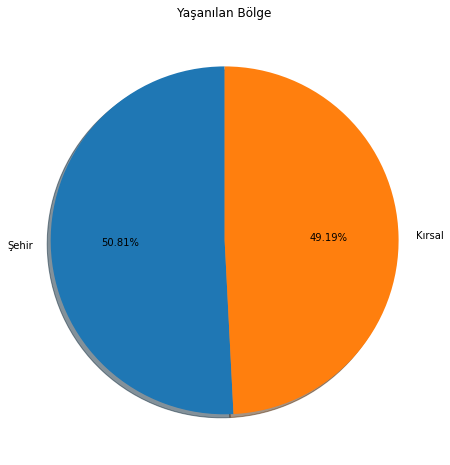

In [53]:
plt.figure(figsize=(8,8))
plt.pie(df["Residence_type"].value_counts(sort=False),
        labels=["Şehir", "Kırsal"],
        startangle=90,
        autopct="%.2f%%",
        shadow=True
       )

plt.title("Yaşanılan Bölge")
plt.show()

## Yaşanılan Bölgeye Göre Felç
### İstatistik için verilerin analizi ve hazırlanması

In [54]:
istatistik_data6 = pd.DataFrame(columns=["Felç Geçiren", "Felç Geçiren Oran", "Felç Geçirmeyen", "Felç Geçirmeyen Oran"])
istatistik_data6.insert(0, "Residence_type", df["Residence_type"].unique())
istatistik_data6.fillna(0, inplace=True)
istatistik_data6

,Residence_type,Felç Geçiren,Felç Geçiren Oran,Felç Geçirmeyen,Felç Geçirmeyen Oran
0,Urban,0,0,0,0
1,Rural,0,0,0,0


In [55]:
# Kişi sayısını bulma
for i in range(len(istatistik_data6)):
    istatistik_data6.loc[i, "Felç Geçiren"] = len(df.query('Residence_type=="' + str(istatistik_data6.loc[i, "Residence_type"]) + '" and stroke==1'))
    istatistik_data6.loc[i, "Felç Geçirmeyen"] = len(df.query('Residence_type=="' + str(istatistik_data6.loc[i, "Residence_type"]) + '" and stroke==0'))
       
# Kişi sayısını oranlama
for i in range(len(istatistik_data6)):
    istatistik_data6.loc[i, "Felç Geçiren Oran"] = istatistik_data6.loc[i, "Felç Geçiren"]/sum(istatistik_data6["Felç Geçiren"])*100
    istatistik_data6.loc[i, "Felç Geçirmeyen Oran"] = istatistik_data6.loc[i, "Felç Geçirmeyen"]/sum(istatistik_data6["Felç Geçirmeyen"])*100

istatistik_data6["Residence_type"] = istatistik_data6["Residence_type"].replace({"Urban": "Şehir", "Rural": "Kırsal"})
istatistik_data6

,Residence_type,Felç Geçiren,Felç Geçiren Oran,Felç Geçirmeyen,Felç Geçirmeyen Oran
0,Şehir,135,54.216867,2461,50.63786
1,Kırsal,114,45.783133,2399,49.36214


### Bar grafiğinde gösterim

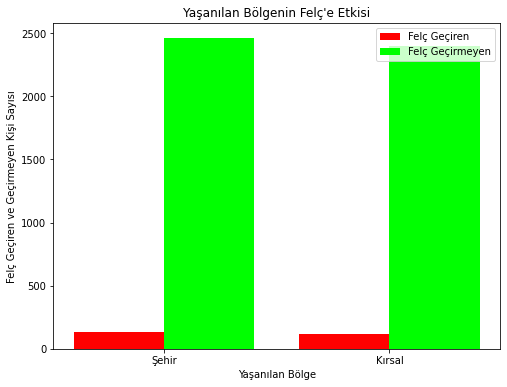

In [56]:
X_Residence_type_axis = np.arange(len(istatistik_data6["Residence_type"]))

plt.figure(figsize=(8,6))
plt.bar(X_Residence_type_axis - 0.2, istatistik_data6["Felç Geçiren"], 0.4, color="red", label = "Felç Geçiren")
plt.bar(X_Residence_type_axis + 0.2, istatistik_data6["Felç Geçirmeyen"], 0.4, color="lime", label = "Felç Geçirmeyen")
plt.xticks(X_Residence_type_axis, istatistik_data6["Residence_type"])
plt.xlabel("Yaşanılan Bölge")
plt.ylabel("Felç Geçiren ve Geçirmeyen Kişi Sayısı")
plt.title("Yaşanılan Bölgenin Felç'e Etkisi")
plt.legend()
plt.show()

## Evlilik Oranları
### Verinin analizi ve hazırlanması

In [57]:
print(df["ever_married"].unique())
df["ever_married"].value_counts(sort=False)

['Yes' 'No']


Yes    3353
No     1756
Name: ever_married, dtype: int64

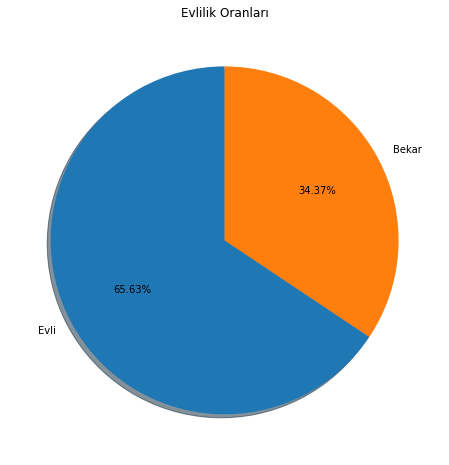

In [58]:
plt.figure(figsize=(8,8))
plt.pie(df["ever_married"].value_counts(sort=False),
        labels=["Evli", "Bekar"],
        startangle=90,
        autopct="%.2f%%",
        shadow=True
       )

plt.title("Evlilik Oranları")
plt.show()

## Evliliğe Göre Felç
### İstatistik için veri analizi ve hazırlanması

In [59]:
istatistik_data7 = pd.DataFrame(columns=["Felç Geçiren", "Felç Geçiren Oran", "Felç Geçirmeyen", "Felç Geçirmeyen Oran"])
istatistik_data7.insert(0, "ever_married", df["ever_married"].unique())
istatistik_data7.fillna(0, inplace=True)
istatistik_data7

,ever_married,Felç Geçiren,Felç Geçiren Oran,Felç Geçirmeyen,Felç Geçirmeyen Oran
0,Yes,0,0,0,0
1,No,0,0,0,0


In [60]:
# Kişi sayısını bulma
for i in range(len(istatistik_data7)):
    istatistik_data7.loc[i, "Felç Geçiren"] = len(df.query('ever_married=="' + str(istatistik_data7.loc[i, "ever_married"]) + '" and stroke==1'))
    istatistik_data7.loc[i, "Felç Geçirmeyen"] = len(df.query('ever_married=="' + str(istatistik_data7.loc[i, "ever_married"]) + '" and stroke==0'))
       
# Kişi sayısını oranlama
for i in range(len(istatistik_data7)):
    istatistik_data7.loc[i, "Felç Geçiren Oran"] = istatistik_data7.loc[i, "Felç Geçiren"]/sum(istatistik_data7["Felç Geçiren"])*100
    istatistik_data7.loc[i, "Felç Geçirmeyen Oran"] = istatistik_data7.loc[i, "Felç Geçirmeyen"]/sum(istatistik_data7["Felç Geçirmeyen"])*100

istatistik_data7["ever_married"] = istatistik_data7["ever_married"].replace({"Yes": "Evli", "No": "Bekar"})
istatistik_data7

,ever_married,Felç Geçiren,Felç Geçiren Oran,Felç Geçirmeyen,Felç Geçirmeyen Oran
0,Evli,220,88.353414,3133,64.465021
1,Bekar,29,11.646586,1727,35.534979


### Bar grafiğiyle gösterim

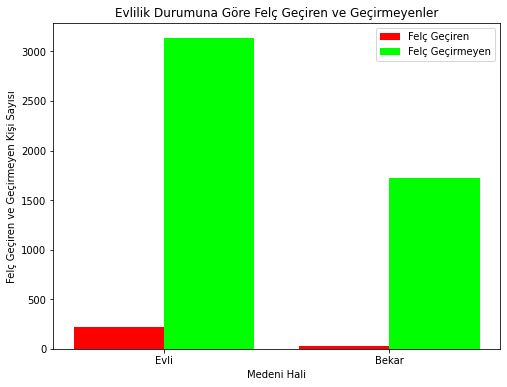

In [61]:
X_ever_married_axis = np.arange(len(istatistik_data7["ever_married"]))

plt.figure(figsize=(8,6))
plt.bar(X_ever_married_axis - 0.2, istatistik_data7["Felç Geçiren"], 0.4, color="red", label = "Felç Geçiren")
plt.bar(X_ever_married_axis + 0.2, istatistik_data7["Felç Geçirmeyen"], 0.4, color="lime", label = "Felç Geçirmeyen")
plt.xticks(X_ever_married_axis, istatistik_data7["ever_married"])
plt.xlabel("Medeni Hali")
plt.ylabel("Felç Geçiren ve Geçirmeyen Kişi Sayısı")
plt.title("Evlilik Durumuna Göre Felç Geçiren ve Geçirmeyenler")
plt.legend()
plt.show()

### Oranlayarak Bar grafiğinde gösterim

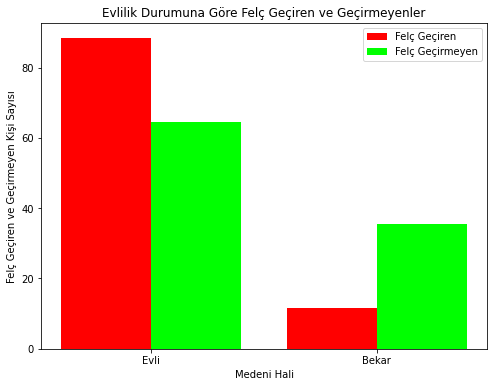

In [62]:
X_ever_married_axis = np.arange(len(istatistik_data7["ever_married"]))

plt.figure(figsize=(8,6))
plt.bar(X_ever_married_axis - 0.2, istatistik_data7["Felç Geçiren Oran"], 0.4, color="red", label = "Felç Geçiren")
plt.bar(X_ever_married_axis + 0.2, istatistik_data7["Felç Geçirmeyen Oran"], 0.4, color="lime", label = "Felç Geçirmeyen")
plt.xticks(X_ever_married_axis, istatistik_data7["ever_married"])
plt.xlabel("Medeni Hali")
plt.ylabel("Felç Geçiren ve Geçirmeyen Kişi Sayısı")
plt.title("Evlilik Durumuna Göre Felç Geçiren ve Geçirmeyenler")
plt.legend()
plt.show()

## Vücut Kitle Endeksine Göre Felç
### İstatistik için verilerin analizi ve hazırlanması

In [63]:
len(df["bmi"].unique())

529

In [64]:
max(df["bmi"].unique())

97.6

In [65]:
min(df["bmi"].unique())

10.3

In [66]:
istatistik_data8 = pd.DataFrame(columns=["Kişi Sayısı", "Felç"])
istatistik_data8.insert(0, "bmi_aralik", list(range(10, 100, 10)))
istatistik_data8.fillna(0, inplace=True)
istatistik_data8["bmi_aralik"] = istatistik_data8["bmi_aralik"].astype(np.float64)
istatistik_data8

,bmi_aralik,Kişi Sayısı,Felç
0,10.0,0,0
1,20.0,0,0
2,30.0,0,0
3,40.0,0,0
4,50.0,0,0
5,60.0,0,0
6,70.0,0,0
7,80.0,0,0
8,90.0,0,0


In [67]:
for i in range(len(istatistik_data8)):
    for d in range(len(df["stroke"])):
        if df.loc[d, "bmi"] >= istatistik_data8.loc[i, "bmi_aralik"] and df.loc[d, "bmi"] < (istatistik_data8.loc[i, "bmi_aralik"]+10):
            istatistik_data8.loc[i, "Kişi Sayısı"] += 1
        
        if df.loc[d, "bmi"] >= istatistik_data8.loc[i, "bmi_aralik"] and df.loc[d, "bmi"] < (istatistik_data8.loc[i, "bmi_aralik"]+10) and df.loc[d, "stroke"] == 1:
            istatistik_data8.loc[i, "Felç"] += 1

istatistik_data8



,bmi_aralik,Kişi Sayısı,Felç
0,10.0,533,4
1,20.0,2538,126
2,30.0,1624,100
3,40.0,335,18
4,50.0,66,1
5,60.0,9,0
6,70.0,2,0
7,80.0,0,0
8,90.0,2,0


In [68]:
sum(istatistik_data8["Kişi Sayısı"])

5109

In [69]:
# Karşılaştırma için verileri 1-0 arasına sıkıştırıyorum
istatistik_data8["Kişi Sayısı"] = istatistik_data8["Kişi Sayısı"]/max(istatistik_data8["Kişi Sayısı"])
istatistik_data8["Felç"] = istatistik_data8["Felç"]/max(istatistik_data8["Felç"])
istatistik_data8

,bmi_aralik,Kişi Sayısı,Felç
0,10.0,0.210008,0.031746
1,20.0,1.000000,1.000000
2,30.0,0.639874,0.793651
3,40.0,0.131994,0.142857
4,50.0,0.026005,0.007937
5,60.0,0.003546,0.000000
6,70.0,0.000788,0.000000
7,80.0,0.000000,0.000000
8,90.0,0.000788,0.000000


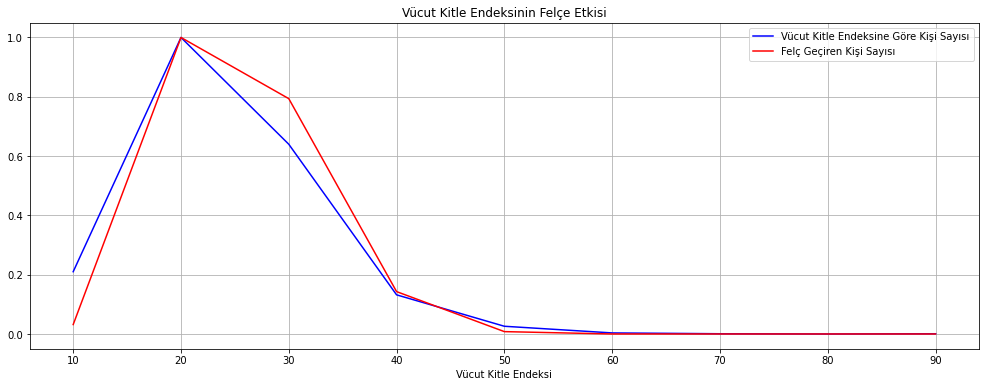

In [70]:
plt.figure(figsize=(17,6))
plt.title("Vücut Kitle Endeksinin Felçe Etkisi")
plt.plot(istatistik_data8["bmi_aralik"], istatistik_data8["Kişi Sayısı"], color="blue", label="Vücut Kitle Endeksine Göre Kişi Sayısı")
plt.plot(istatistik_data8["bmi_aralik"], istatistik_data8["Felç"], color="red", label="Felç Geçiren Kişi Sayısı")
plt.grid(True)
plt.xlabel("Vücut Kitle Endeksi")
plt.legend()
plt.show()

## Kandaki Ortalama Glikoz Seviyesinin Felçe Etkisi
### İstatistik için verilerin analizi ve hazırlanması

In [71]:
len(df["avg_glucose_level"].unique())

3978

In [72]:
max(df["avg_glucose_level"])

271.74

In [73]:
min(df["avg_glucose_level"])

55.12

In [74]:
istatistik_data9 = pd.DataFrame(columns=["Kişi Sayısı", "Felç"])
istatistik_data9.insert(0, "glikoz_aralik", list(range(50, 290, 10)))
istatistik_data9.fillna(0, inplace=True)
istatistik_data9["glikoz_aralik"] = istatistik_data9["glikoz_aralik"].astype(np.float64)
istatistik_data9

,glikoz_aralik,Kişi Sayısı,Felç
0,50.0,0,0
1,60.0,0,0
2,70.0,0,0
3,80.0,0,0
4,90.0,0,0
5,100.0,0,0
6,110.0,0,0
7,120.0,0,0
8,130.0,0,0
9,140.0,0,0


In [75]:
for i in range(len(istatistik_data9)):
    for d in range(len(df["stroke"])):
        if df.loc[d, "avg_glucose_level"] >= istatistik_data9.loc[i, "glikoz_aralik"] and df.loc[d, "avg_glucose_level"] < (istatistik_data9.loc[i, "glikoz_aralik"]+10):
            istatistik_data9.loc[i, "Kişi Sayısı"] += 1
        
        if df.loc[d, "avg_glucose_level"] >= istatistik_data9.loc[i, "glikoz_aralik"] and df.loc[d, "avg_glucose_level"] < (istatistik_data9.loc[i, "glikoz_aralik"]+10) and df.loc[d, "stroke"] == 1:
            istatistik_data9.loc[i, "Felç"] += 1

istatistik_data9

,glikoz_aralik,Kişi Sayısı,Felç
0,50.0,220,8
1,60.0,534,19
2,70.0,776,36
3,80.0,872,25
4,90.0,729,24
5,100.0,506,20
6,110.0,354,15
7,120.0,198,4
8,130.0,100,5
9,140.0,89,3


In [76]:
# Karşılaştırma için verileri 1-0 arasına sıkıştırıyorum
istatistik_data9["Kişi Sayısı"] = istatistik_data9["Kişi Sayısı"]/max(istatistik_data9["Kişi Sayısı"])
istatistik_data9["Felç"] = istatistik_data9["Felç"]/max(istatistik_data9["Felç"])
istatistik_data9

,glikoz_aralik,Kişi Sayısı,Felç
0,50.0,0.252294,0.222222
1,60.0,0.612385,0.527778
2,70.0,0.889908,1.000000
3,80.0,1.000000,0.694444
4,90.0,0.836009,0.666667
5,100.0,0.580275,0.555556
6,110.0,0.405963,0.416667
7,120.0,0.227064,0.111111
8,130.0,0.114679,0.138889
9,140.0,0.102064,0.083333


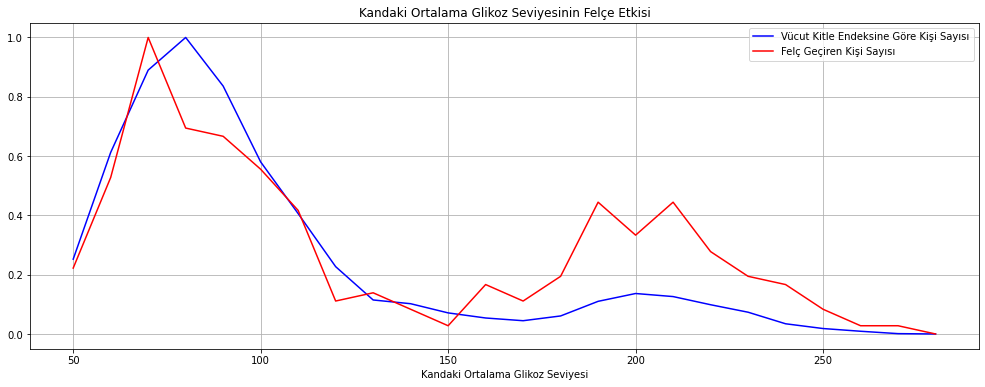

In [77]:
plt.figure(figsize=(17,6))
plt.title("Kandaki Ortalama Glikoz Seviyesinin Felçe Etkisi")
plt.plot(istatistik_data9["glikoz_aralik"], istatistik_data9["Kişi Sayısı"], color="blue", label="Vücut Kitle Endeksine Göre Kişi Sayısı")
plt.plot(istatistik_data9["glikoz_aralik"], istatistik_data9["Felç"], color="red", label="Felç Geçiren Kişi Sayısı")
plt.grid(True)
plt.xlabel("Kandaki Ortalama Glikoz Seviyesi")
plt.legend()
plt.show()

## Kandaki Glikoz ve Vücut Kitle Endeksi
### Verilerin hazırlaması ve analizi

In [78]:
stroke_0 = df[df["stroke"] == 0]
stroke_1 = df[df["stroke"] == 1]

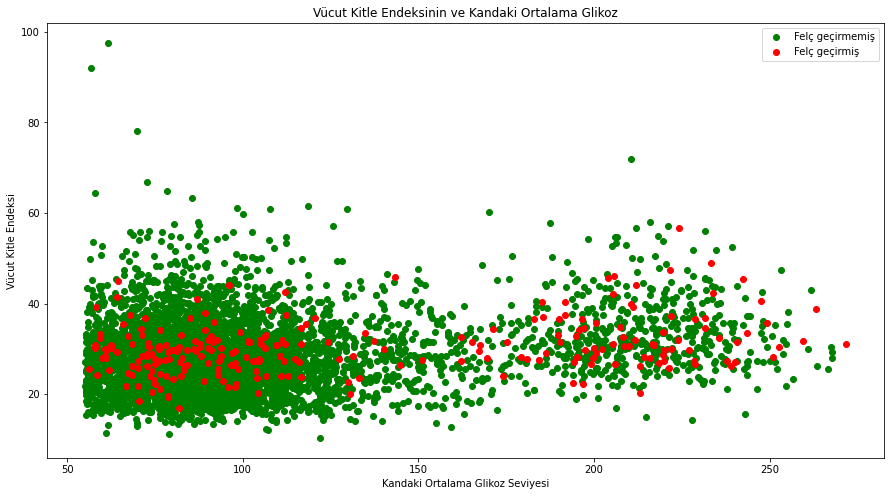

In [79]:
plt.figure(figsize=(15,8))
plt.title("Vücut Kitle Endeksinin ve Kandaki Ortalama Glikoz")
plt.scatter(stroke_0["avg_glucose_level"], stroke_0["bmi"], color="green", label="Felç geçirmemiş")
plt.scatter(stroke_1["avg_glucose_level"], stroke_1["bmi"], color="red", label="Felç geçirmiş")

plt.xlabel("Kandaki Ortalama Glikoz Seviyesi")
plt.ylabel("Vücut Kitle Endeksi")
plt.legend()
plt.show()

## Vücut Kitle endeksi ve Yaşa Göre

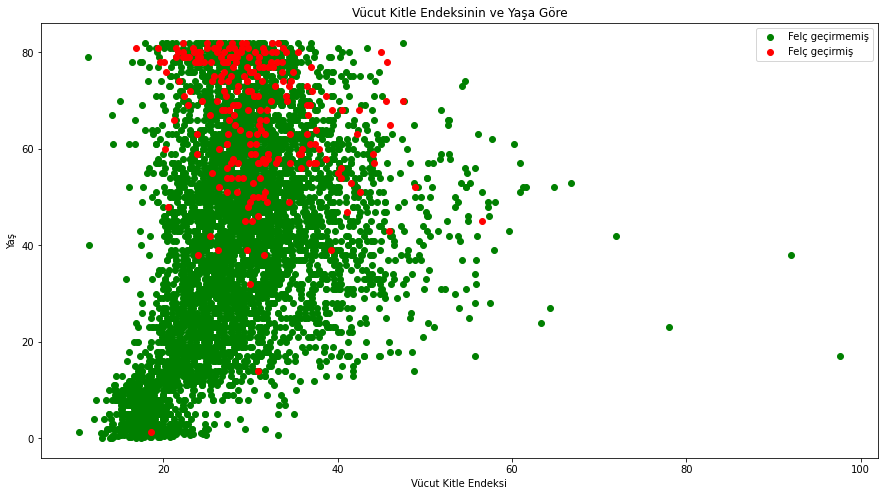

In [80]:
plt.figure(figsize=(15,8))
plt.title("Vücut Kitle Endeksinin ve Yaşa Göre")
plt.scatter(stroke_0["bmi"], stroke_0["age"], color="green", label="Felç geçirmemiş")
plt.scatter(stroke_1["bmi"], stroke_1["age"], color="red", label="Felç geçirmiş")

plt.xlabel("Vücut Kitle Endeksi")
plt.ylabel("Yaş")
plt.legend()
plt.show()

## Kandaki Ortalama Glikoz ve Yaşa Göre

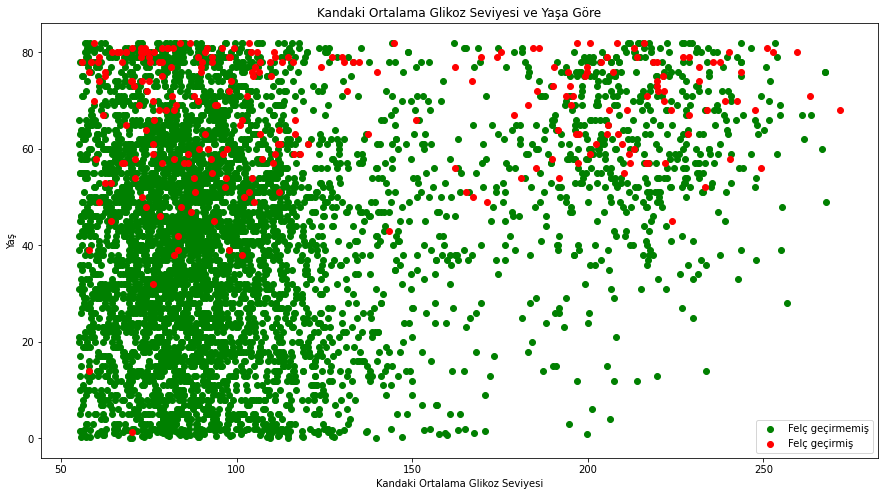

In [81]:
plt.figure(figsize=(15,8))
plt.title("Kandaki Ortalama Glikoz Seviyesi ve Yaşa Göre")
plt.scatter(stroke_0["avg_glucose_level"], stroke_0["age"], color="green", label="Felç geçirmemiş")
plt.scatter(stroke_1["avg_glucose_level"], stroke_1["age"], color="red", label="Felç geçirmiş")

plt.xlabel("Kandaki Ortalama Glikoz Seviyesi")
plt.ylabel("Yaş")
plt.legend()
plt.show()

### İstatitiklerin bitişi

# CLASSIFICATION TAHMİN İŞLEMLERİ